In [1]:
import math
import psycopg2
import datetime
import numpy as np
import pandas as pd
from itertools import islice
from sklearn import preprocessing

import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

import torch
from torch import nn, optim

from finance.utilities import utils
from finance.data_science.utilities import (financial_utils, time_series_utils, 
                                            cluster_utils, random_forest_utils, nn_utils)

### Get stock data

In [2]:
date_start = '2005-01-01'
date_end = '2019-01-01'
query = f"""
    with 
    tickers as (
    select distinct 
        ticker
        , sector
        , industry
    from nasdaq.listed_stocks
    where ticker !~ '[\^.~]'
        and character_length(ticker) between 1 and 4
    limit 20
    )
    select 
        symbol
        , market_datetime
        , open
    from td.equities as equities
    inner join tickers
        on tickers.ticker = equities.symbol
    where market_datetime > '{date_start}' and market_datetime < '{date_end}'
    order by market_datetime
    """

df = utils.query_db(query=query)
df.head()

,symbol,market_datetime,open
0,ABC,2005-01-03 06:00:00,14.67
1,AB,2005-01-03 06:00:00,42.25
2,ABB,2005-01-03 06:00:00,5.72
3,ABR,2005-01-03 06:00:00,24.39
4,ABG,2005-01-03 06:00:00,13.80


### Check data

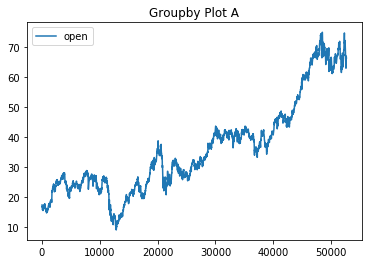

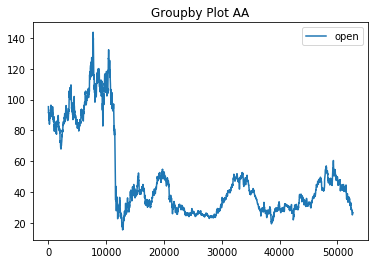

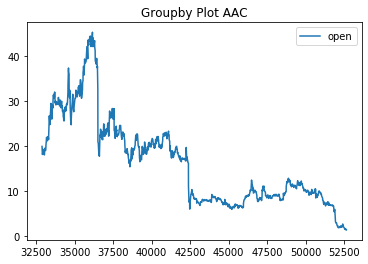

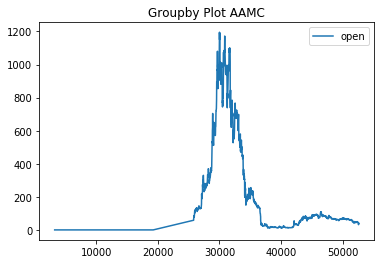

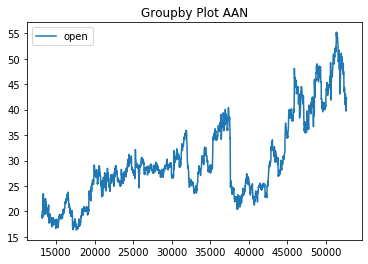

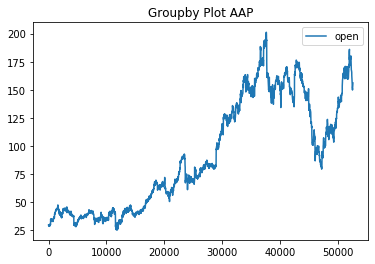

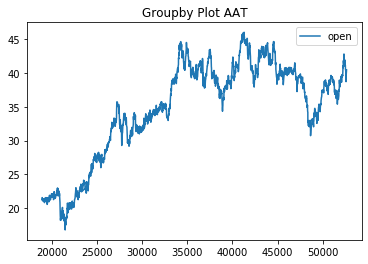

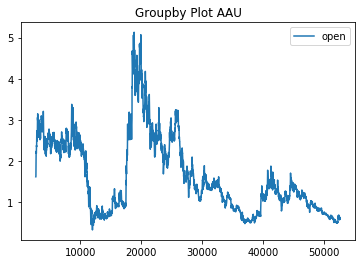

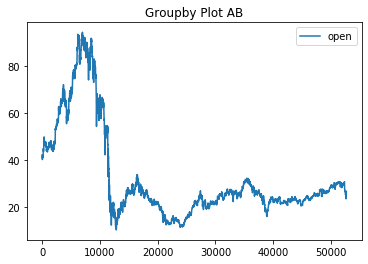

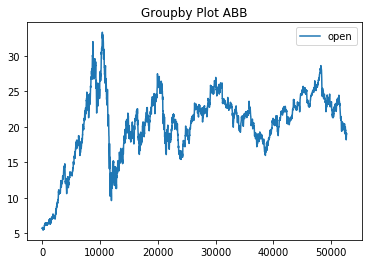

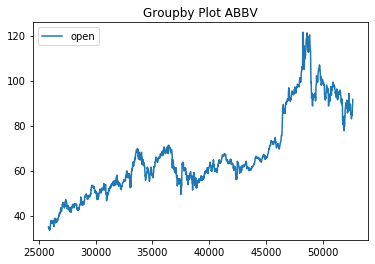

In [3]:
cluster_utils.plot_groupby(df, 'symbol', lines=['open'])

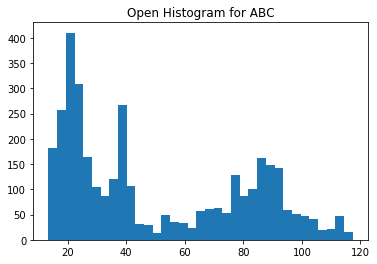

In [4]:
plt.hist(df.loc[df['symbol']==df['symbol'].values[0], 'open'], bins=35)
plt.title('Open Histogram for ' + df['symbol'].values[0])
plt.show()

### Clean data

In [5]:
def normalize(df, column='open', window_size=1000):
    df['open_min'] = df[column].rolling(window_size).min()
    df['open_max'] = df[column].rolling(window_size).max()
    df[column] = ((df[column] - df['open_min']) / (df['open_max'] - df['open_min']))
    return df

In [6]:
df['target'] = df['open']
df['open_min'], df['open_max'] = 0, 0

df = df.groupby('symbol').apply(normalize)
df = df[df['open'].notnull()]

In [7]:
df = cluster_utils.encode_one_hot(df, ['symbol'])

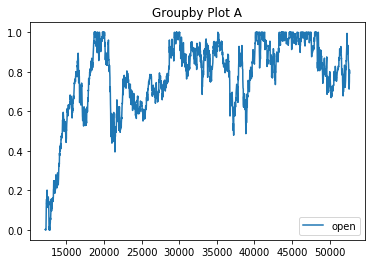

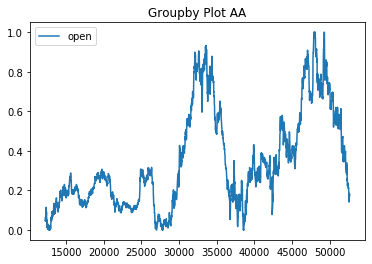

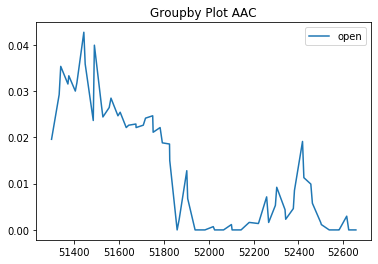

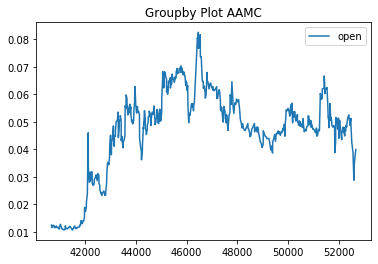

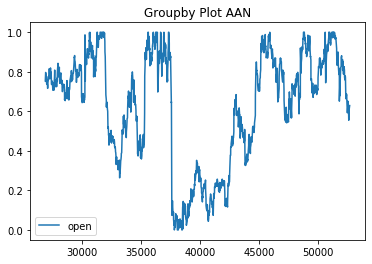

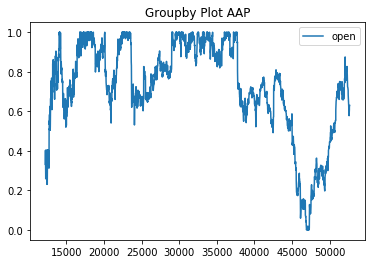

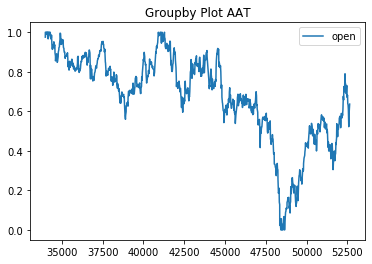

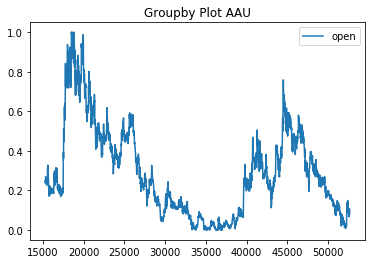

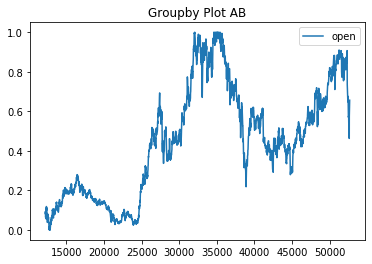

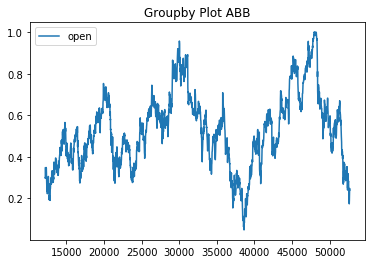

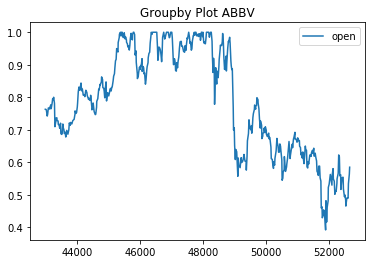

In [8]:
cluster_utils.plot_groupby(df, 'symbol', lines=['open'])

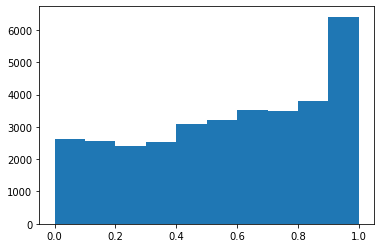

In [9]:
plt.hist(df['open'])
plt.show()

In [10]:
def sequence_data(df, column='open', length=100):
    dfs = []
    for offset in range(1, length, 1):
        df = df.join(df[column].shift(offset), rsuffix='_' + str(abs(offset)))
    return df

train_test = df.groupby('symbol').apply(sequence_data)


train_test = train_test.dropna()
train_test = train_test.sort_values(by='market_datetime')

print(train_test.shape)
train_test.head(10)

(31995, 122)


,symbol,market_datetime,open,target,open_min,open_max,symbol_A,symbol_AA,symbol_AAC,symbol_AAMC,...,open_90,open_91,open_92,open_93,open_94,open_95,open_96,open_97,open_98,open_99
13401,ABR,2009-05-12 05:00:00,0.059332,2.420000,0.430000,33.970000,0,0,0,0,...,0.023581,0.019547,0.032578,0.039094,0.043438,0.041266,0.040025,0.023891,0.024511,0.027304
13402,AB,2009-05-12 05:00:00,0.097194,18.640000,10.500000,94.250000,0,0,0,0,...,0.080896,0.056174,0.059723,0.063150,0.068413,0.063762,0.078448,0.082487,0.092889,0.083099
13404,ABT,2009-05-12 05:00:00,0.322470,21.560840,17.962582,29.121011,0,0,0,0,...,0.673671,0.641509,0.670240,0.654803,0.645798,0.669382,0.636792,0.662950,0.635077,0.646655
13405,ABM,2009-05-12 05:00:00,0.251813,16.760000,11.900000,31.200000,0,0,0,0,...,0.290055,0.268508,0.279558,0.275691,0.278453,0.272376,0.274033,0.271823,0.267956,0.251381
13407,ABG,2009-05-12 05:00:00,0.269299,9.520000,1.950000,30.060000,0,0,0,0,...,0.089648,0.088225,0.082177,0.069015,0.062255,0.069370,0.092494,0.094628,0.103522,0.083600
13410,AAP,2009-05-12 05:00:00,0.741694,41.520000,25.000000,47.273330,0,0,0,0,...,0.364113,0.299910,0.296319,0.292727,0.258605,0.283747,0.339419,0.402724,0.369500,0.331787
13411,ABC,2009-05-12 05:00:00,0.297857,17.870000,13.770000,27.535000,0,0,0,0,...,0.284978,0.266844,0.264356,0.260444,0.258311,0.264711,0.277156,0.268267,0.257244,0.283911
13424,AB,2009-05-13 05:00:00,0.085015,17.620000,10.500000,94.250000,0,0,0,0,...,0.103292,0.080896,0.056174,0.059723,0.063150,0.068413,0.063762,0.078448,0.082487,0.092889
13422,ABM,2009-05-13 05:00:00,0.236269,16.460000,11.900000,31.200000,0,0,0,0,...,0.309945,0.290055,0.268508,0.279558,0.275691,0.278453,0.272376,0.274033,0.271823,0.267956
13421,ABT,2009-05-13 05:00:00,0.326329,21.603904,17.962582,29.121011,0,0,0,0,...,0.685678,0.673671,0.641509,0.670240,0.654803,0.645798,0.669382,0.636792,0.662950,0.635077


### Train lstm

Epoch  0 Error:  9707.2607421875
Epoch  50 Error:  3503.263671875
Epoch  100 Error:  2807.391357421875
Epoch  150 Error:  1162.577392578125
Epoch  200 Error:  973.5532836914062
Epoch  250 Error:  826.55029296875
Epoch  300 Error:  724.1067504882812
Epoch  350 Error:  666.5932006835938
Epoch  400 Error:  623.8524169921875
Epoch  450 Error:  584.45654296875


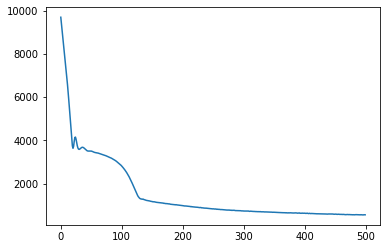

In [11]:
cols_to_ignore = ['symbol', 'market_datetime', 'open', 'open_min', 'open_max', 'target']

data_size = int(round(len(train_test)/2, -2))
model = nn_utils.TorchLSTM(train_x=train_test.drop(cols_to_ignore, axis=1).head(data_size), 
                           train_y=train_test['open'].head(data_size), 
                           test_x=train_test.drop(cols_to_ignore, axis=1).tail(data_size), 
                           test_y=train_test['open'].tail(data_size),
                           n_layers=2,
                           n_epochs=500,
                           hidden_shape=300,
                           batch_size=int(data_size/100),
                           dropout=.1,
                           learning_rate=.0001,
                           device='cuda:0')

model.execute()
model.reset_network()

### Analyze predictions

In [12]:
test_df = model.test_df

temp = train_test[cols_to_ignore].tail(data_size).reset_index(drop=True)
test_df = test_df.join(temp)
test_df.head()

,symbol_A,symbol_AA,symbol_AAC,symbol_AAMC,symbol_AAN,symbol_AAP,symbol_AAT,symbol_AAU,symbol_AB,symbol_ABB,...,open_98,open_99,actuals,prediction,symbol,market_datetime,open,open_min,open_max,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.616189,0.626648,0.962415,0.899960,AB,2014-08-26 05:00:00,0.962415,11.62,27.850000,27.240000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.945511,0.970564,0.946482,0.907648,ABG,2014-08-27 05:00:00,0.946482,12.35,72.890000,69.650000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.833447,0.851575,0.979620,0.989667,ABC,2014-08-27 05:00:00,0.979620,27.94,77.990000,76.970000
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.456173,0.467483,0.841659,0.835830,AA,2014-08-27 05:00:00,0.841659,23.04,54.870003,49.830003
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.917891,0.921348,0.774417,0.696839,ABM,2014-08-27 05:00:00,0.774417,17.54,29.110000,26.500000


In [13]:
test_df['prediction_mapped'] = (test_df['prediction'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']
test_df['actuals_mapped'] = (test_df['actuals'] * (test_df['open_max'] - test_df['open_min'])) + test_df['open_min']
test_df['errors'] = test_df['prediction'] - test_df['actuals']

test_df.head(10)

,symbol_A,symbol_AA,symbol_AAC,symbol_AAMC,symbol_AAN,symbol_AAP,symbol_AAT,symbol_AAU,symbol_AB,symbol_ABB,...,prediction,symbol,market_datetime,open,open_min,open_max,target,prediction_mapped,actuals_mapped,errors
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.899960,AB,2014-08-26 05:00:00,0.962415,11.62000,27.850000,27.240000,26.226349,27.240000,-0.062455
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.907648,ABG,2014-08-27 05:00:00,0.946482,12.35000,72.890000,69.650000,67.299026,69.649999,-0.038833
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.989667,ABC,2014-08-27 05:00:00,0.979620,27.94000,77.990000,76.970000,77.472842,76.970001,0.010047
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.835830,AA,2014-08-27 05:00:00,0.841659,23.04000,54.870003,49.830003,49.644474,49.830003,-0.005829
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.696839,ABM,2014-08-27 05:00:00,0.774417,17.54000,29.110000,26.500000,25.602427,26.500000,-0.077578
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.443602,AAN,2014-08-27 05:00:00,0.462293,16.54000,35.900000,25.490000,25.128135,25.490000,-0.018691
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.598731,ABB,2014-08-27 05:00:00,0.631841,15.40000,27.460000,23.020000,22.620696,23.020000,-0.033110
7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.902320,A,2014-08-27 05:00:00,0.911452,20.65093,43.512160,41.487840,41.279082,41.487840,-0.009131
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.552718,ABEV,2014-08-27 05:00:00,0.561676,4.53520,9.422000,7.280000,7.236220,7.280000,-0.008959
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.705723,ABR,2014-08-27 05:00:00,0.727278,3.07990,8.250000,6.840000,6.728560,6.840000,-0.021555


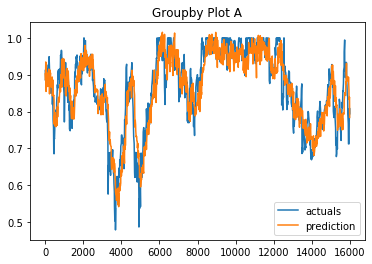

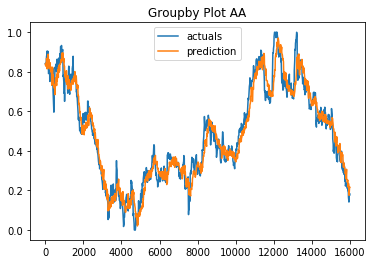

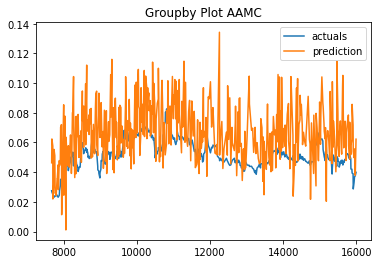

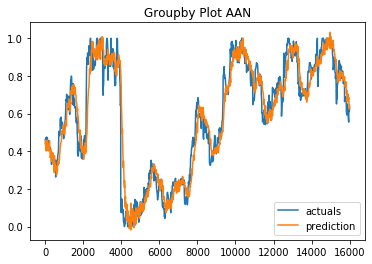

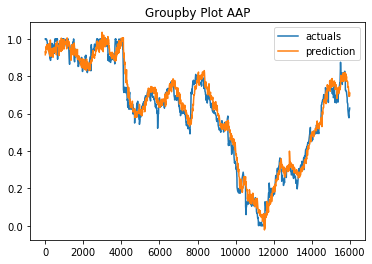

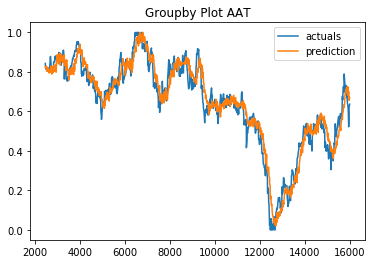

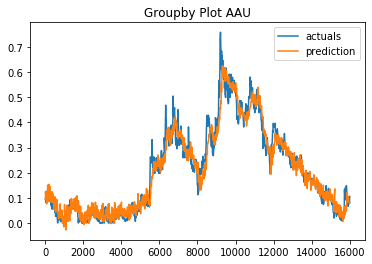

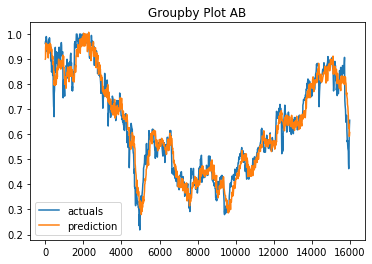

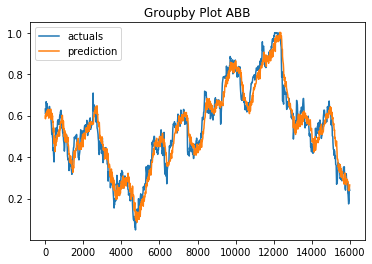

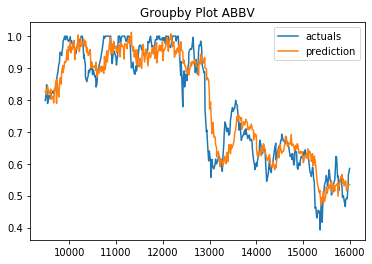

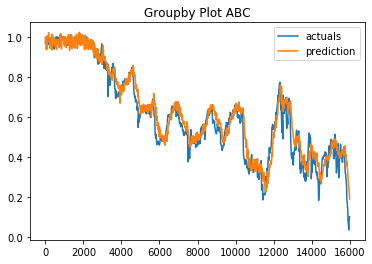

In [14]:
cluster_utils.plot_groupby(test_df, 'symbol', lines=['actuals', 'prediction'])

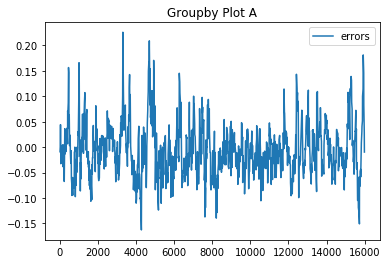

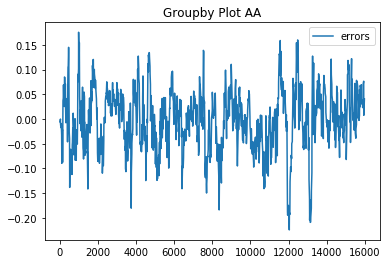

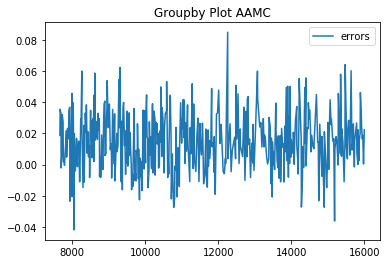

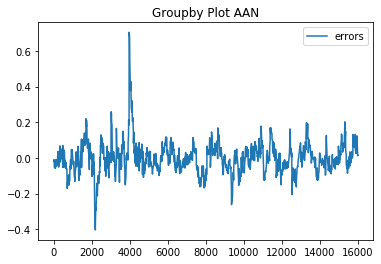

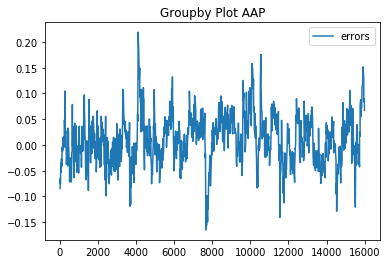

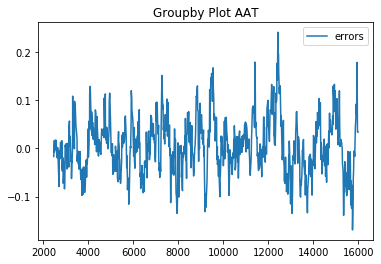

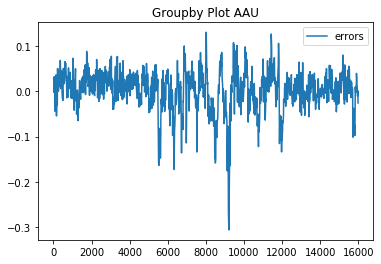

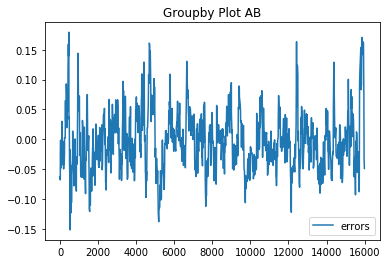

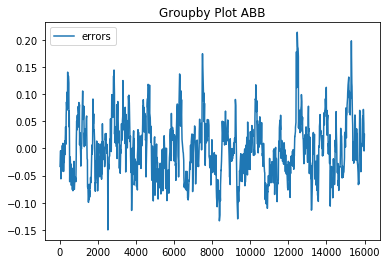

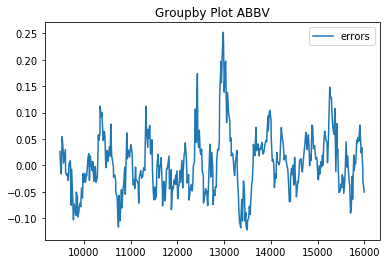

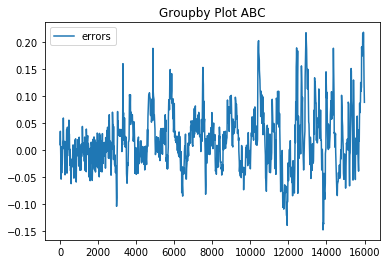

In [15]:
cluster_utils.plot_groupby(test_df, 'symbol', lines=['errors'])

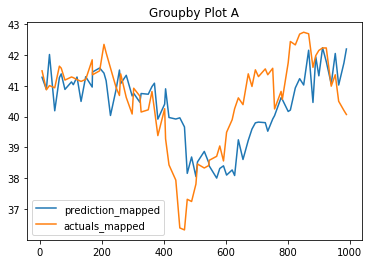

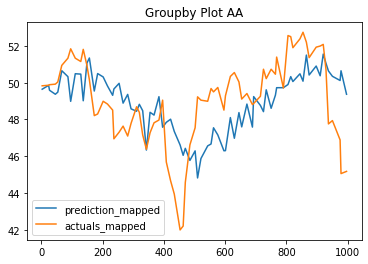

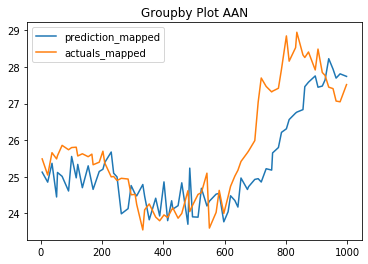

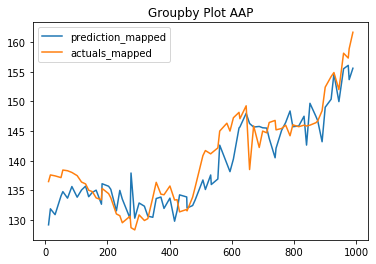

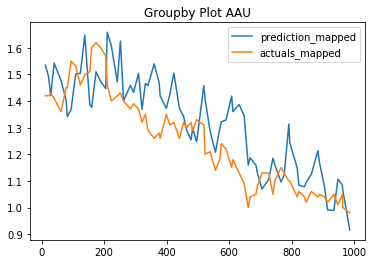

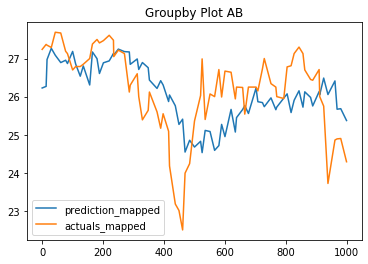

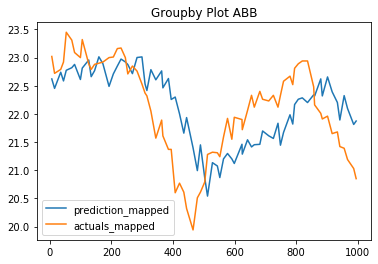

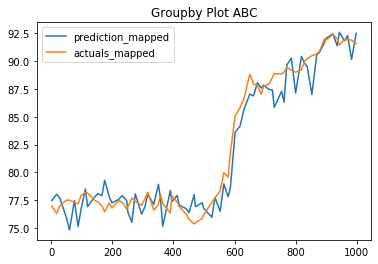

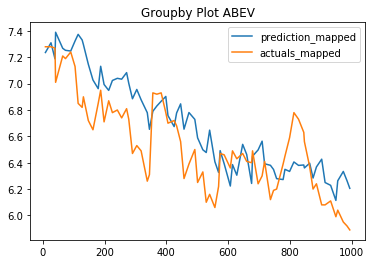

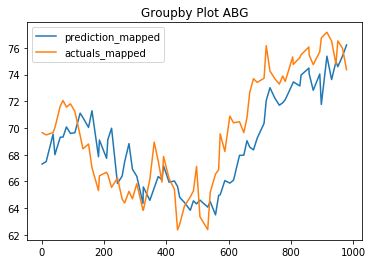

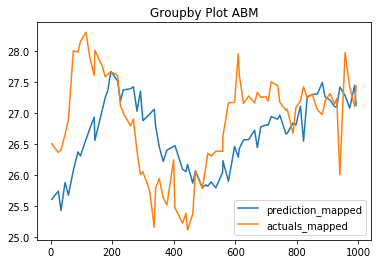

In [16]:
cluster_utils.plot_groupby(test_df.head(1000), 'symbol', lines=['prediction_mapped', 'actuals_mapped'])

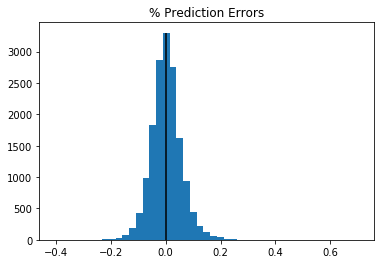

In [17]:
plt.title('% Prediction Errors')
plot = plt.hist(test_df['errors'], bins=45)
plt.vlines(0, ymin=0, ymax=plot[0].max())
plt.show()

### Size bets

In [18]:
cols = ['symbol', 'market_datetime', 'prediction_mapped', 'actuals_mapped']

trades = test_df[cols]
trades = trades.join(test_df.groupby('symbol')['prediction_mapped'].shift(-1), rsuffix='_t+1')
trades = trades.join(test_df.groupby('symbol')['actuals_mapped'].shift(-1), rsuffix='_t+1')
trades = trades.join(test_df.groupby('symbol')['actuals_mapped'].shift(1), rsuffix='_t-1')
trades = trades.dropna()

# determine trade direction(s)
trades['current_trade'] = 'neutral'
trades.loc[trades['prediction_mapped'] > trades['actuals_mapped_t-1'], 'current_trade'] = 'long'
trades.loc[trades['prediction_mapped'] < trades['actuals_mapped_t-1'], 'current_trade'] = 'short'

# predict profits
trades['predicted_profits'] = abs(trades['prediction_mapped_t+1'] - trades['actuals_mapped'])

# calculate actual profits
trades['actual_profits'] = 0
trades.loc[trades['current_trade']=='long', 'actual_profits'] = trades.loc[trades['current_trade']=='long', 'actuals_mapped'] - trades.loc[trades['current_trade']=='long', 'actuals_mapped_t-1']
trades.loc[trades['current_trade']=='short', 'actual_profits'] = trades.loc[trades['current_trade']=='short', 'actuals_mapped_t-1'] - trades.loc[trades['current_trade']=='short', 'actuals_mapped']

trades[trades['symbol']==trades['symbol'].values[0]].head(10)

,symbol,market_datetime,prediction_mapped,actuals_mapped,prediction_mapped_t+1,actuals_mapped_t+1,actuals_mapped_t-1,current_trade,predicted_profits,actual_profits
13,AB,2014-08-27 05:00:00,26.268496,27.37,26.973683,27.35,27.24,short,0.396317,-0.130000
16,AB,2014-08-28 05:00:00,26.973683,27.35,27.267576,27.29,27.37,short,0.082424,0.020000
30,AB,2014-08-29 05:00:00,27.267576,27.29,27.087007,27.69,27.35,short,0.202993,0.060000
43,AB,2014-09-02 05:00:00,27.087007,27.69,26.893442,27.67,27.29,short,0.796558,-0.399999
61,AB,2014-09-03 05:00:00,26.893442,27.67,26.955182,27.19,27.69,short,0.714818,0.020000
77,AB,2014-09-04 05:00:00,26.955182,27.19,26.869253,27.13,27.67,short,0.320747,0.480000
83,AB,2014-09-05 05:00:00,26.869253,27.13,27.186419,26.70,27.19,short,0.056419,0.060000
100,AB,2014-09-08 05:00:00,27.186419,26.70,26.854091,26.79,27.13,long,0.154092,-0.430000
110,AB,2014-09-09 05:00:00,26.854091,26.79,26.536397,26.79,26.70,long,0.253603,0.090001
125,AB,2014-09-10 05:00:00,26.536397,26.79,26.804217,26.85,26.79,short,0.014217,0.000000


In [19]:
def kelly_criterion(predicted_win, predicted_loss, p_win, p_loss):
    bet_size = (predicted_win * p_win - predicted_loss * p_loss) / predicted_win
    return bet_size

def get_rolling_kelly_criterion(df, column='open', window_size=100):
    df['is_win'] = False
    df.loc[df['actual_profits'] > 0, 'is_win'] = True
    
    df['win_rate'] = (df['is_win'].rolling(window_size).sum()
                      /df['is_win'].rolling(window_size).count())
    
    df['estimated_loss'] = abs(df['actual_profits']).rolling(window_size).median()
    
    df['kelly'] = kelly_criterion(df['predicted_profits'], 
                                  df['estimated_loss'], 
                                  df['win_rate'], 
                                  1 - df['win_rate'])
    return df.drop(['is_win', 'win_rate'], axis=1)

trades = trades.groupby('symbol').apply(get_rolling_kelly_criterion)
trades = trades.dropna()
trades.tail(10)

,symbol,market_datetime,prediction_mapped,actuals_mapped,prediction_mapped_t+1,actuals_mapped_t+1,actuals_mapped_t-1,current_trade,predicted_profits,actual_profits,estimated_loss,kelly
15974,ABEV,2018-12-28 06:00:00,3.918799,3.890000,3.918038,3.870000,3.860000,long,0.028038,0.030000,0.065000,-0.625976
15975,ABC,2018-12-28 06:00:00,79.833757,73.900000,78.363325,74.090000,72.230000,long,4.463325,1.670000,0.895000,0.411744
15976,AAMC,2018-12-28 06:00:00,38.304374,38.040001,55.617926,39.690001,37.430000,long,17.577924,0.610001,1.490001,0.414227
15977,AAU,2018-12-28 06:00:00,0.591707,0.590000,0.593775,0.630000,0.615900,short,0.003775,0.025900,0.016500,-1.739016
15978,ABM,2018-12-28 06:00:00,28.408646,31.040000,28.820810,31.340000,30.680000,short,2.219189,-0.360000,0.415000,0.394627
15979,A,2018-12-28 06:00:00,68.215002,66.980000,65.934271,66.340000,64.500000,long,1.045729,2.480000,0.575000,0.194075
15980,AAN,2018-12-28 06:00:00,42.101573,41.670000,42.798624,42.290001,41.509999,long,1.128624,0.160001,0.700000,0.092674
15981,AAP,2018-12-28 06:00:00,166.206402,155.339999,164.239573,156.050000,153.439998,long,8.899574,1.900001,1.545001,0.448406
15982,AA,2018-12-28 06:00:00,28.467278,27.090000,28.406230,26.750000,26.410000,long,1.316230,0.680000,0.760000,0.432134
15983,ABR,2018-12-28 06:00:00,10.812027,10.230000,10.776593,10.280000,10.070000,long,0.546594,0.160000,0.080000,0.415356


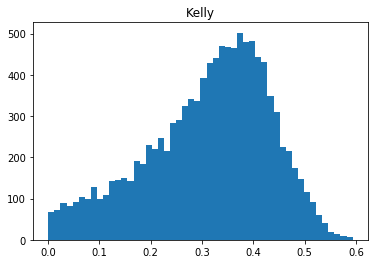

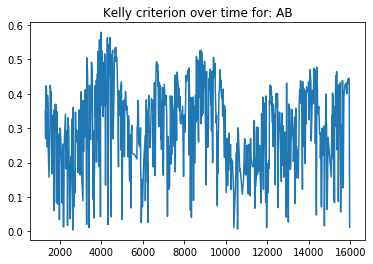

In [20]:
plt.title('Kelly')
plt.hist(trades.loc[trades['kelly'] > 0, 'kelly'], bins=50)
plt.show()

plt.title('Kelly criterion over time for: ' + trades['symbol'].values[0])
plt.plot(trades.loc[(trades['symbol']==trades['symbol'].values[0]) & (trades['kelly'] > 0), 'kelly'])
plt.show()

### Create portfolio

In [21]:
def allocate_portfolio(df, budget):
    positive_kelly = df['kelly'] > 0
    potential_positions = df.sort_values(by='kelly', ascending=False)['kelly'].cumsum() < 1
    positions = (potential_positions.cumsum() - potential_positions.reset_index().index) > 0
    df.loc[positions, 'n_shares'] = ((df.loc[positions, 'kelly'] * budget)/df.loc[positions, 'actuals_mapped']).astype(int)
    df.loc[positions, 'position'] = df.loc[positions, 'n_shares'] * df.loc[positions, 'actuals_mapped']
    return df

def calculate_profits(df):
    df.loc[df['current_trade']=='long', 'trade_profits'] = (df.loc[df['current_trade']=='long', 'n_shares'] * 
                                                            (df.loc[df['current_trade']=='long', 'actuals_mapped_t+1'] - df.loc[df['current_trade']=='long', 'actuals_mapped']))
    df.loc[df['current_trade']=='short', 'trade_profits'] = (df.loc[df['current_trade']=='short', 'n_shares'] * 
                                                             (df.loc[df['current_trade']=='short', 'actuals_mapped'] - df.loc[df['current_trade']=='short', 'actuals_mapped_t+1']))
    return df

budget = 1000
trades['position'] = 0
trades['n_shares'] = 0

budgets = []
for day, temp in trades.groupby('market_datetime'):
    positions = allocate_portfolio(temp, budget)
    results = calculate_profits(positions)
    budget = budget + results['trade_profits'].sum()
    budgets.append(budget)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/user/miniconda/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


In [22]:
positions

,symbol,market_datetime,prediction_mapped,actuals_mapped,prediction_mapped_t+1,actuals_mapped_t+1,actuals_mapped_t-1,current_trade,predicted_profits,actual_profits,estimated_loss,kelly,position,n_shares,trade_profits
15968,ABBV,2018-12-28 06:00:00,87.864714,90.090000,87.938487,91.599999,87.949999,short,2.151513,-2.140002,0.999998,0.252958,0.000000,0,-0.000000
15969,ABT,2018-12-28 06:00:00,69.326514,71.050001,69.809523,71.570000,68.410000,long,1.240478,2.640000,0.559999,0.274281,0.000000,0,0.000000
15970,AAT,2018-12-28 06:00:00,40.770170,40.250000,40.987198,40.470000,39.580000,long,0.737198,0.670001,0.330000,0.305132,0.000000,0,0.000000
15971,ABG,2018-12-28 06:00:00,66.614109,64.940000,65.444035,65.969999,64.010000,long,0.504035,0.929999,0.755001,-0.373852,0.000000,0,0.000000
15972,AB,2018-12-28 06:00:00,25.771147,26.280000,26.025346,26.820000,25.510000,long,0.254654,0.770000,0.255000,-0.000679,0.000000,0,0.000000
15973,ABB,2018-12-28 06:00:00,19.041920,19.100000,19.317591,18.990000,18.370000,long,0.217591,0.730000,0.210000,-0.041510,0.000000,0,-0.000000
15974,ABEV,2018-12-28 06:00:00,3.918799,3.890000,3.918038,3.870000,3.860000,long,0.028038,0.030000,0.065000,-0.625976,0.000000,0,-0.000000
15975,ABC,2018-12-28 06:00:00,79.833757,73.900000,78.363325,74.090000,72.230000,long,4.463325,1.670000,0.895000,0.411744,0.000000,0,0.000000
15976,AAMC,2018-12-28 06:00:00,38.304374,38.040001,55.617926,39.690001,37.430000,long,17.577924,0.610001,1.490001,0.414227,0.000000,0,0.000000
15977,AAU,2018-12-28 06:00:00,0.591707,0.590000,0.593775,0.630000,0.615900,short,0.003775,0.025900,0.016500,-1.739016,0.000000,0,-0.000000


In [23]:
results

,symbol,market_datetime,prediction_mapped,actuals_mapped,prediction_mapped_t+1,actuals_mapped_t+1,actuals_mapped_t-1,current_trade,predicted_profits,actual_profits,estimated_loss,kelly,position,n_shares,trade_profits
15968,ABBV,2018-12-28 06:00:00,87.864714,90.090000,87.938487,91.599999,87.949999,short,2.151513,-2.140002,0.999998,0.252958,0.000000,0,-0.000000
15969,ABT,2018-12-28 06:00:00,69.326514,71.050001,69.809523,71.570000,68.410000,long,1.240478,2.640000,0.559999,0.274281,0.000000,0,0.000000
15970,AAT,2018-12-28 06:00:00,40.770170,40.250000,40.987198,40.470000,39.580000,long,0.737198,0.670001,0.330000,0.305132,0.000000,0,0.000000
15971,ABG,2018-12-28 06:00:00,66.614109,64.940000,65.444035,65.969999,64.010000,long,0.504035,0.929999,0.755001,-0.373852,0.000000,0,0.000000
15972,AB,2018-12-28 06:00:00,25.771147,26.280000,26.025346,26.820000,25.510000,long,0.254654,0.770000,0.255000,-0.000679,0.000000,0,0.000000
15973,ABB,2018-12-28 06:00:00,19.041920,19.100000,19.317591,18.990000,18.370000,long,0.217591,0.730000,0.210000,-0.041510,0.000000,0,-0.000000
15974,ABEV,2018-12-28 06:00:00,3.918799,3.890000,3.918038,3.870000,3.860000,long,0.028038,0.030000,0.065000,-0.625976,0.000000,0,-0.000000
15975,ABC,2018-12-28 06:00:00,79.833757,73.900000,78.363325,74.090000,72.230000,long,4.463325,1.670000,0.895000,0.411744,0.000000,0,0.000000
15976,AAMC,2018-12-28 06:00:00,38.304374,38.040001,55.617926,39.690001,37.430000,long,17.577924,0.610001,1.490001,0.414227,0.000000,0,0.000000
15977,AAU,2018-12-28 06:00:00,0.591707,0.590000,0.593775,0.630000,0.615900,short,0.003775,0.025900,0.016500,-1.739016,0.000000,0,-0.000000


Annualized P/L 0.526451


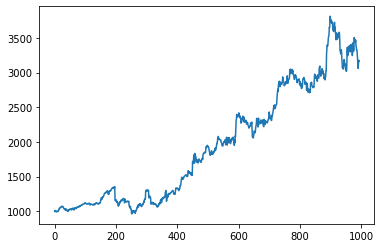

In [24]:
annualized_return = (1+((budgets[-1]-budgets[0])/budgets[0]))**(365/len(budgets))-1
print('Annualized P/L ' + str(round(annualized_return, 6)))

plt.plot(budgets)
plt.show()

### Comparision

In [46]:
start = trades[trades['market_datetime']==trades['market_datetime'].values[1]]
end = trades[trades['market_datetime']==trades['market_datetime'].values[-1]]
comp = pd.merge(start, end, on='symbol')

((comp['actuals_mapped_y'] - comp['actuals_mapped_x'])/comp['actuals_mapped_x']).sort_values(ascending=False)

10    0.774305
5     0.616242
1     0.524590
8     0.405870
4     0.071084
11    0.018690
12    0.011158
2    -0.034866
0    -0.077295
7    -0.200043
6    -0.403374
9    -0.419293
3    -0.508333
dtype: float64